# <center>Etude du dataset au niveau de la maille visiteur

## Chargement des données

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joblib
sns.set()

In [2]:
df = pd.read_csv('data/featured_events.csv', index_col=0)
df.head()

C:\ProgramData\Anaconda3\envs\py_e_sales\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,timestamp,visitorid,event,itemid,transactionid,addtocart,transaction,view,date,month,...,hourclass_1,hourclass_2,hourclass_3,hourclass_4,hourclass_5,hourclass_6,changementsession,time_for_view,time_for_addtocart,time_for_transaction
1361687,1442004589439,0,view,285930,NaN,0,0,1,2015-09-11 20:49:49.439,9,...,0,0,0,0,0,1,False,2.835867,NaN,NaN
1367212,1442004759591,0,view,357564,NaN,0,0,1,2015-09-11 20:52:39.591,9,...,0,0,0,0,0,1,False,2.626400,NaN,NaN
1367342,1442004917175,0,view,67045,NaN,0,0,1,2015-09-11 20:55:17.175,9,...,0,0,0,0,0,1,False,NaN,NaN,NaN
830385,1439487966444,1,view,72028,NaN,0,0,1,2015-08-13 17:46:06.444,8,...,0,0,0,0,1,0,False,NaN,NaN,NaN
742616,1438969904567,2,view,325215,NaN,0,0,1,2015-08-07 17:51:44.567,8,...,0,0,0,0,1,0,False,1.820383,NaN,NaN


## Aggrégation des données autour de la maille visiteur

L'objectif de cette analyse va etre de regrouper les données par visiteur. Le but final sera de faire un model de prédiction de potentiel d'achat lors de leur passage sur le site. 

In [3]:
vis = df.groupby('visitorid').agg(nb_event = ('itemid','count'),
                                  nb_unique_item = ('itemid', lambda x:x.nunique()),
                                  nb_view = ('view','sum'),
                                  nb_addtocart = ('addtocart','sum'),
                                  nb_transaction = ('transaction','sum'),
                                  nb_transactionid = ('transactionid',lambda x: x.nunique()),
                                  nb_interruptionnav = ('changementsession','sum'),
                                  nb_event_of_most_interesting_item = ('itemid', lambda x: x.value_counts().max()),
                                  mean_diftime = ('diftime(m)','mean'),
                                  std_diftime = ('diftime(m)','std'),
                                  full_time_session = ('timestamp', lambda x: (x.max()-x.min())/60000), #conversion en minutes
                                  mean_time_per_view = ('time_for_view','mean'),
                                  mean_time_per_addtocart = ('time_for_addtocart', 'mean'),
                                  nb_hclass1 = ('hourclass_1','sum'),
                                  nb_hclass2 = ('hourclass_2','sum'),
                                  nb_hclass3 = ('hourclass_3','sum'),
                                  nb_hclass4 = ('hourclass_4','sum'),
                                  nb_hclass5 = ('hourclass_5','sum'),
                                  nb_hclass6 = ('hourclass_6','sum'),
                                  nb_week_end = ('weekend','sum'))


Pour décrire les visiteurs, nous avons choisi d'utiliser 20 variables:
   - nb_event: le nombre de clic effectué par un même utilisateur
   - nb_unique_item: le nombre de produits différents qu'un client a consulté. Plus ce chiffre est bas plus le visiteur
        aura fait des action sur le même produits et plus cela montre un intéret pour ce produit 
   - nb_view: le nombre d'action 'view' réalisées par un même client
   - nb_addtocart: le nombre d'action 'addtocart' réalisées par un même client
   - nb_transaction: le nombre d'action 'transaction' réalisées par un même client
   - nb_transactionid: le nombre d'action 'transactionid' réalisées par un même client. Ce nombre est différent de
        nb_transaction car un transactionid peut concerner plusieurs produits. 
   - nb_interruptionnav: Lorsque qu'un visisteur reste inactif plus de 13h entre deux clics, On considère qu'a la reprise
        qu'il a oublié de fermer son navigateur et donc que cela correspond à une nouvelle session de navigation. 
   - nb_event_of_most_interesting_item: Parmi les articles vu par un même client, on s'intéresse à l'article le plus vu.
        On récupère le nombre d'event lié à cet item. 
   - mean_diftime: moyenne du temps entre deux actions
   - std_diftime: ecart_type du temps entre deux actions
   - full_time_session: temps entre la première action et la dernière action effectuée par un même client
   - mean_time_per_view: moyen du temps passé par action 'view'
   - mean_time_per_addtocart: moyen du temps passé par action 'addtocart'
   - nb_classX: plusieurs plages horaires ont été définies et on comptabilise le nombre d'action pour chaque plage horaire.
        * 1: minuit à 4h(exclus)
        * 2: 4h à 8h(exclus)
        * 3: 8h à 12(exclus)
        * 4: 12h à 16h(exclus)
        * 5: 16 à 20h(exclus)
        * 6: 20 à minuit(exclus)
 
   - nb_week_end: nombre d'action faites le week end

In [4]:
vis.isna().sum()

nb_event                                   0
nb_unique_item                             0
nb_view                                    0
nb_addtocart                               0
nb_transaction                             0
nb_transactionid                           0
nb_interruptionnav                         0
nb_event_of_most_interesting_item          0
mean_diftime                         1001614
std_diftime                          1207621
full_time_session                          0
mean_time_per_view                   1064125
mean_time_per_addtocart              1383139
nb_hclass1                                 0
nb_hclass2                                 0
nb_hclass3                                 0
nb_hclass4                                 0
nb_hclass5                                 0
nb_hclass6                                 0
nb_week_end                                0
dtype: int64

In [5]:
vis.fillna(0, inplace=True)

In [6]:
vis.describe([0.05,0.25,0.5,0.75, 0.95]).round(2)

,nb_event,nb_unique_item,nb_view,nb_addtocart,nb_transaction,nb_transactionid,nb_interruptionnav,nb_event_of_most_interesting_item,mean_diftime,std_diftime,full_time_session,mean_time_per_view,mean_time_per_addtocart,nb_hclass1,nb_hclass2,nb_hclass3,nb_hclass4,nb_hclass5,nb_hclass6,nb_week_end
count,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00,1407580.00
mean,1.96,1.52,1.89,0.05,0.02,0.01,0.16,1.32,6.24,4.59,3420.71,7.37,0.26,0.41,0.28,0.06,0.21,0.50,0.50,0.45
std,12.58,7.14,10.99,1.16,0.83,0.68,0.88,1.38,40.09,30.72,16748.37,46.07,8.31,2.27,1.17,0.51,1.57,5.08,4.74,2.82
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5%,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2.00,1.00,2.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.78,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
95%,5.00,3.00,5.00,0.00,0.00,0.00,1.00,3.00,16.21,6.34,14846.15,18.12,0.00,2.00,1.00,0.00,1.00,2.00,2.00,2.00
max,7757.00,3814.00,6479.00,719.00,559.00,502.00,128.00,308.00,799.76,565.42,198680.92,799.76,793.94,1246.00,245.00,108.00,743.00,3026.00,2742.00,1369.00


Dans cette description du Dataset, on remarque encore le deséquilibre des données. Jusqu'à 50% du dataset, les valeurs des variables sont les valeurs minimums et on voit une augmentation soudaine aux alentours du 95 centile. 

## Création de la variable cible

In [7]:
vis['has_bought'] = vis['nb_transaction']!=0
vis.drop(['nb_transaction', 'nb_transactionid'], axis=True, inplace=True)

Répartition de la variable cible

In [8]:
vis['has_bought'].value_counts(normalize=True)

False    0.991674
True     0.008326
Name: has_bought, dtype: float64

Analyse la moyenne de chaque variable par apport à la target

In [9]:
vis.groupby('has_bought').mean()

,nb_event,nb_unique_item,nb_view,nb_addtocart,nb_interruptionnav,nb_event_of_most_interesting_item,mean_diftime,std_diftime,full_time_session,mean_time_per_view,mean_time_per_addtocart,nb_hclass1,nb_hclass2,nb_hclass3,nb_hclass4,nb_hclass5,nb_hclass6,nb_week_end
has_bought,,,,,,,,,,,,,,,,,,
False,1.808944,1.456735,1.779171,0.029774,0.154225,1.282492,6.161115,4.374926,3324.098885,7.295153,0.184617,0.387903,0.264352,0.055056,0.194262,0.450493,0.456879,0.428189
True,19.677959,9.538271,15.423074,2.338595,1.204540,5.288591,15.720068,30.697138,14927.639506,16.743453,8.943206,3.428364,1.588361,0.263845,1.901783,6.573172,5.922434,3.571124


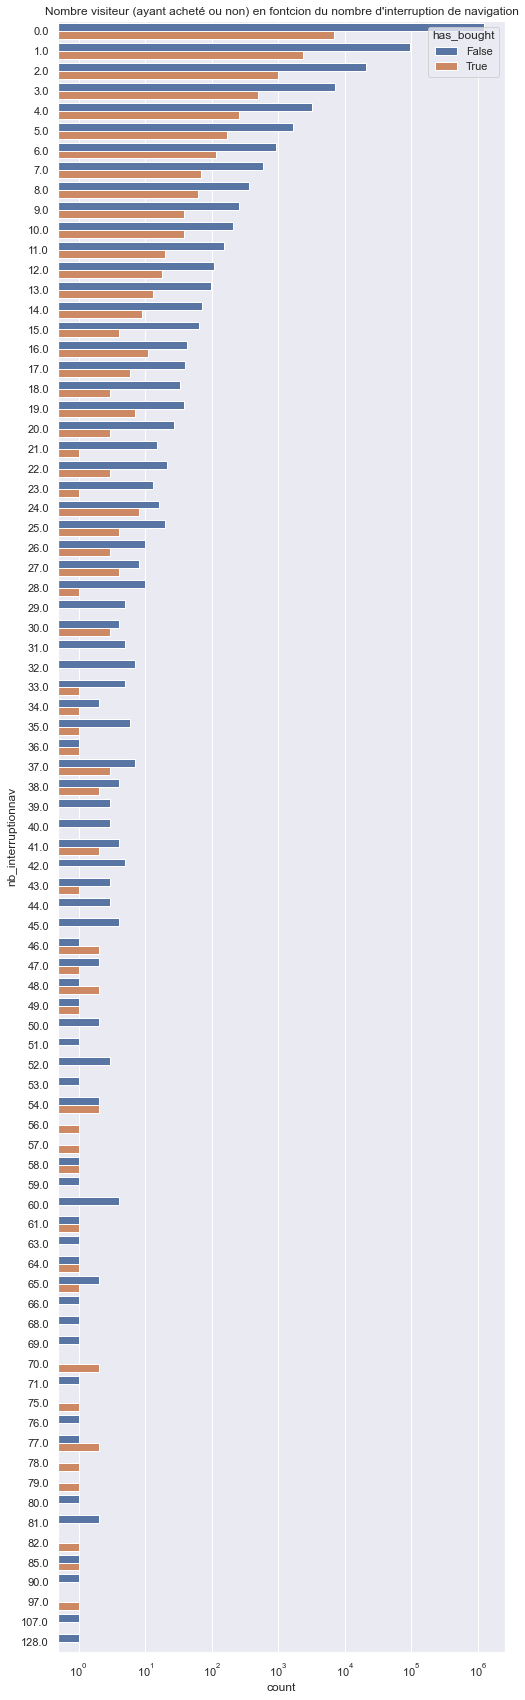

In [10]:
plt.figure(figsize=(8,30))
sns.countplot(data=vis,y='nb_interruptionnav', hue='has_bought')
plt.title("Nombre visiteur (ayant acheté ou non) en fontcion du nombre d'interruption de navigation")
plt.xscale('log');

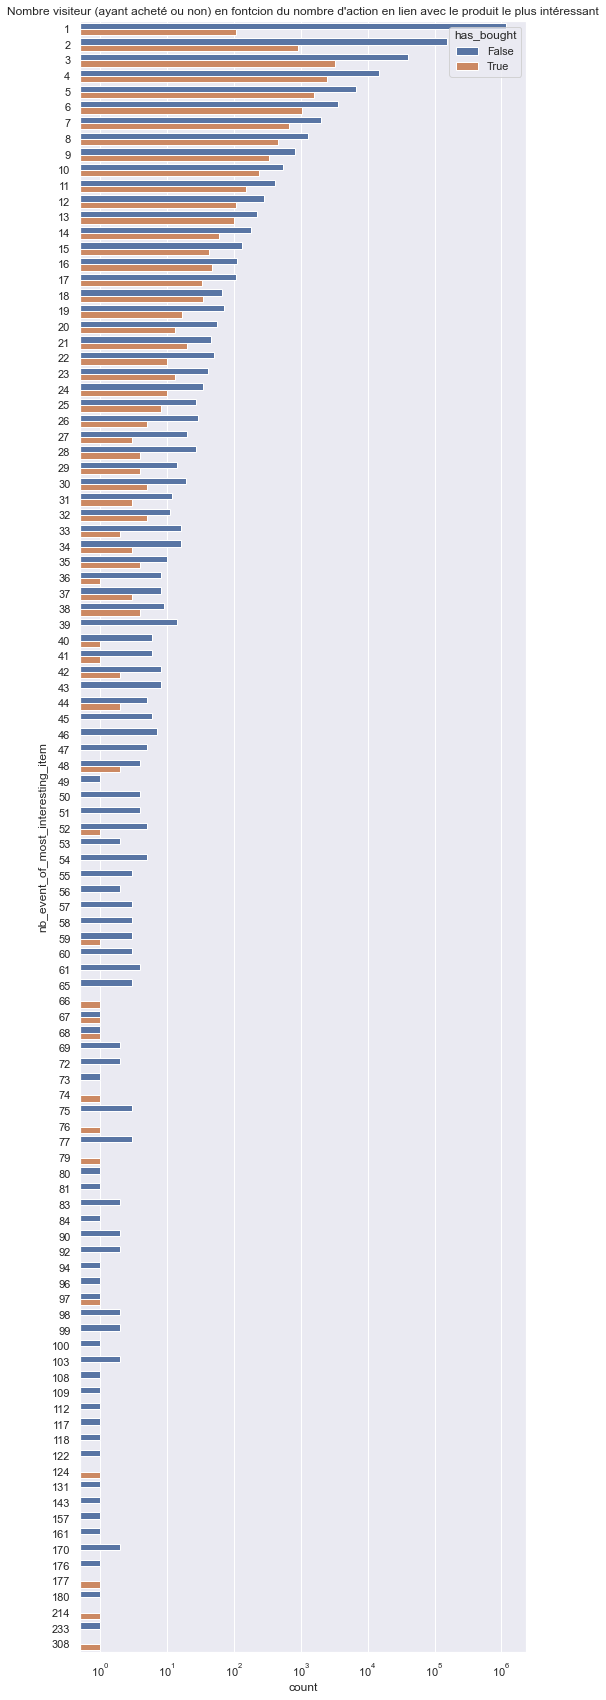

In [11]:
plt.figure(figsize=(8,30))
sns.countplot(data=vis, y='nb_event_of_most_interesting_item', hue='has_bought')
plt.title("Nombre visiteur (ayant acheté ou non) en fontcion du nombre d'action en lien avec le produit le plus intéressant")
plt.xscale('log');

Dans un parcours standard, il faut:
   - 1 event pour voir le produit
   - 1 event pour ajouter le produit
   - 1 event pour acheter le produit<br>
Il parait donc normal que la proportion de visteur ayant acheté soit supérieure pour des nombre d'event par item plus grand ou égal à 3. 

In [12]:
vis.to_csv("data/visitor_df.csv")

In [13]:
vis = pd.read_csv('data/visitor_df.csv', index_col=0)

C:\ProgramData\Anaconda3\envs\py_e_sales\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Classification des visiteurs

On souhaite réaliser une classification pour essayer d'isoler les comportements des visiteurs.

In [16]:
from sklearn.preprocessing import QuantileTransformer

On choisi un quantile scaler plutot qu'un minmax pour garder l'information sur la disparité de la distribution

In [17]:
quantile_scaler = QuantileTransformer()

data = quantile_scaler.fit_transform(vis)

data = pd.DataFrame(data, columns=vis.columns)

In [18]:
data.head()

,nb_event,nb_unique_item,nb_view,nb_addtocart,nb_interruptionnav,nb_event_of_most_interesting_item,mean_diftime,std_diftime,full_time_session,mean_time_per_view,mean_time_per_addtocart,nb_hclass1,nb_hclass2,nb_hclass3,nb_hclass4,nb_hclass5,nb_hclass6,nb_week_end,has_bought
0,0.885385,0.933934,0.892392,0.0,0.0,0.000000,0.890050,0.873786,0.823597,0.886501,0.0,0.0,0.000000,0.0,0.0,0.000000,0.973473,0.000000,0.0
1,0.000000,0.000000,0.360360,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.825325,0.000000,0.000000,0.0
2,0.977477,0.961962,0.979980,0.0,0.0,0.957457,0.908209,0.935862,0.867479,0.906371,0.0,0.0,0.000000,0.0,0.0,0.995996,0.000000,0.000000,0.0
3,0.000000,0.000000,0.360360,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.897397,0.0,0.0,0.000000,0.000000,0.835836,0.0
4,0.000000,0.000000,0.360360,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.823323,0.000000,0.0


In [19]:
joblib.dump(quantile_scaler,"data/quantile_scaler.sav")

['data/quantile_scaler.sav']

In [20]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import time

Méthode du coude afinde déterminé le nombre optimal de cluster

training with nb clusters = 10
training done in 0.89 min, with a distortion of 817890.57
training with nb clusters = 20
training done in 1.53 min, with a distortion of 503868.16
training with nb clusters = 30
training done in 2.19 min, with a distortion of 351955.44
training with nb clusters = 40
training done in 3.60 min, with a distortion of 311708.91
training with nb clusters = 50
training done in 4.95 min, with a distortion of 277970.61
training with nb clusters = 60
training done in 6.12 min, with a distortion of 253601.55
training with nb clusters = 70
training done in 7.28 min, with a distortion of 230412.85
training with nb clusters = 80
training done in 8.40 min, with a distortion of 215641.05
training with nb clusters = 90
training done in 8.89 min, with a distortion of 201194.11


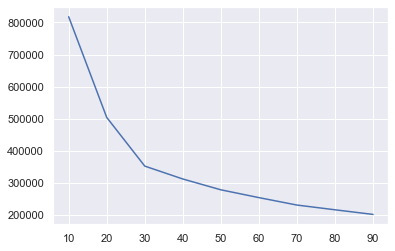

In [21]:
nb_cluster = np.arange(10,100,10)
dist=[]

for k in nb_cluster:
  print(f'training with nb clusters = {k}')
  t = time.time()
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(data)
  mat_dist = cdist(data, kmeans.cluster_centers_)
  d = np.min(mat_dist, axis=1).sum()
  dist.append(d)
  print(f'training done in {(time.time()-t)/60:.2f} min, with a distortion of {d:.2f}')

plt.plot(nb_cluster, dist)

In [22]:
kmeans = KMeans(n_clusters=40).fit(data)

In [23]:
joblib.dump(kmeans,"data/kmeans.sav")

['data/kmeans.sav']

In [24]:
kmeans = joblib.load("data/kmeans.sav")

In [25]:
clusters = pd.DataFrame(kmeans.cluster_centers_, columns= data.columns)

clusters_df = pd.DataFrame(quantile_scaler.inverse_transform(clusters), columns=clusters.columns)


In [26]:
clusters_df.to_csv('data/cluster_df.csv')

In [27]:
clusters_df = pd.read_csv("data/cluster_df.csv", index_col=0)

Représentation des résultats de classification

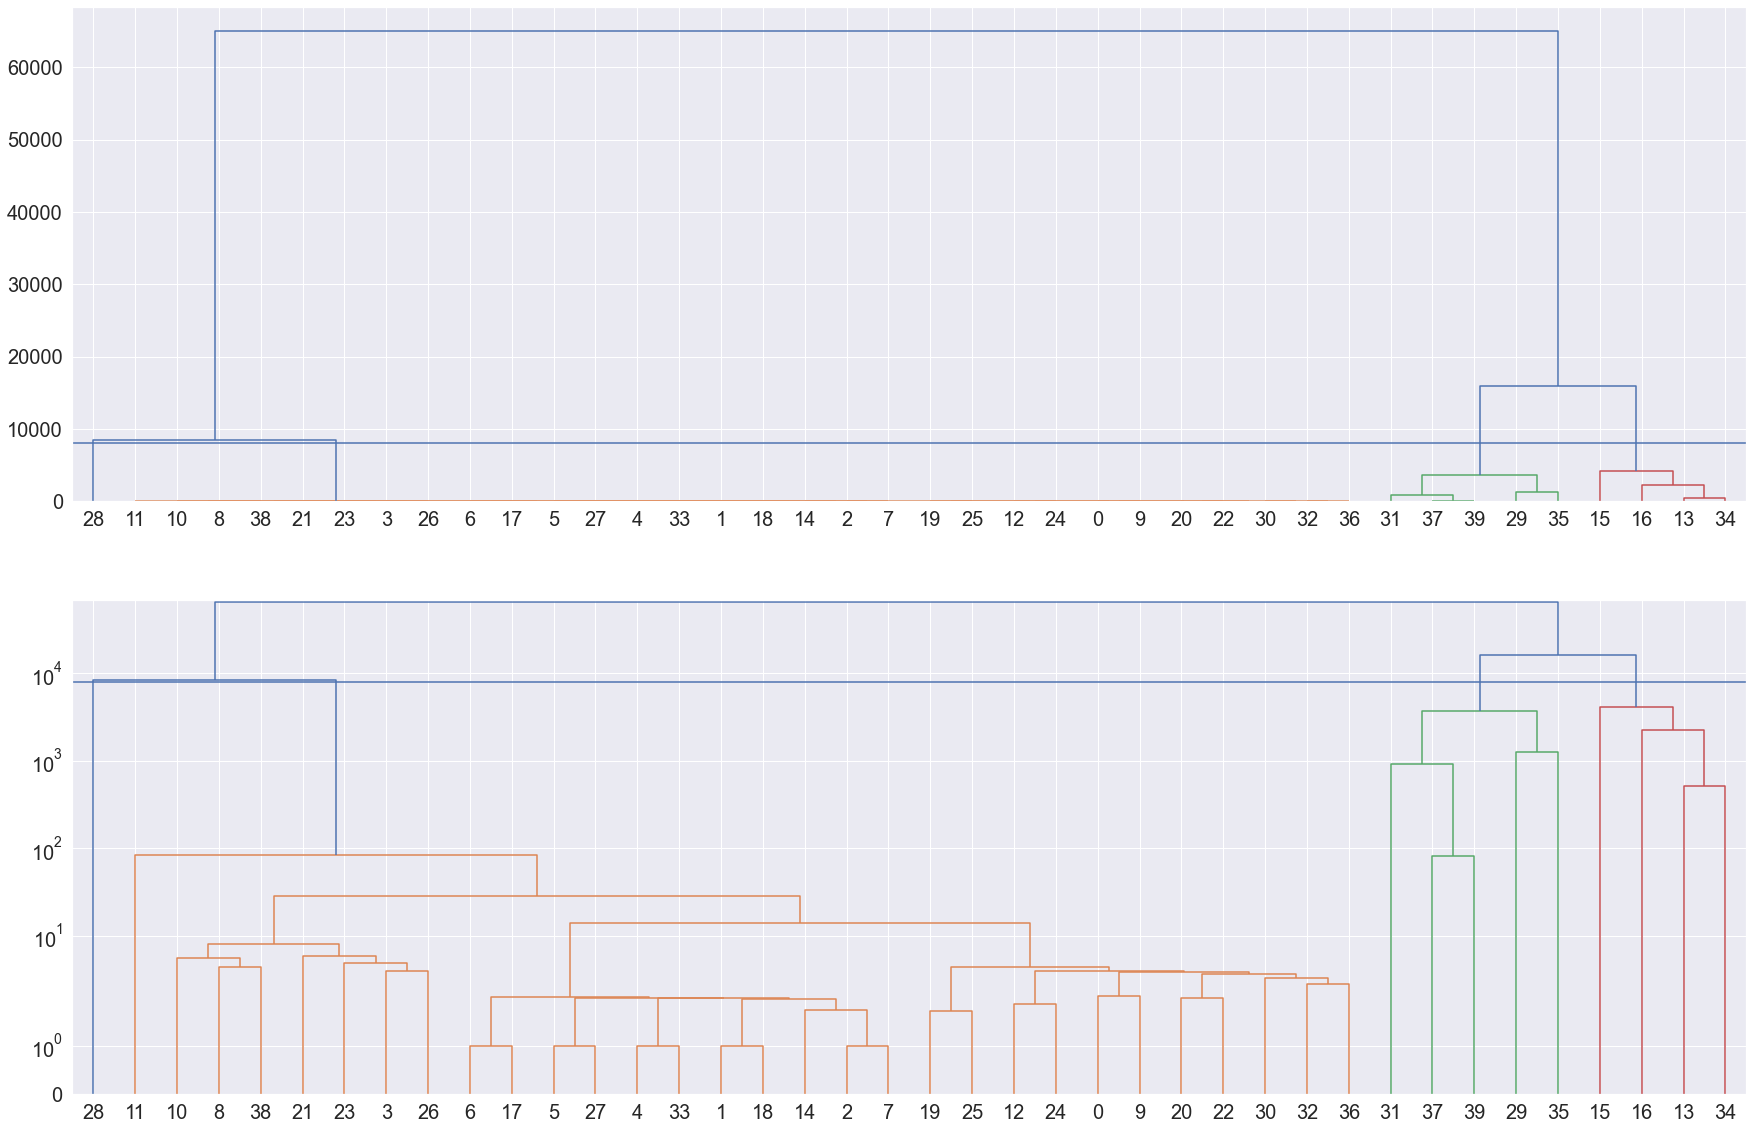

In [30]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(clusters_df, method='ward', metric='euclidean')

fig, axes = plt.subplots(2,1,figsize=(30,20))

t=8000

dendrogram(Z, labels = clusters_df.index, leaf_rotation = 0, color_threshold = t,ax=axes[0])
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[0].axhline(y=t)

dendrogram(Z, labels = clusters_df.index, leaf_rotation = 0, color_threshold = t,ax=axes[1]);
axes[1].tick_params(axis='both', which='major', labelsize=20)
axes[1].axhline(y=t)
axes[1].set_yscale('symlog')

Les clusters 6,17,5,27,4,33,1,18,14,2,7 regroupent les visiteurs n'ayant réalisé qu'une action avec très peu de mauvaise classification

les groupes qui regroupes les visitors ayant un temps de session quasi exclusivement supérieur à 800 minutes sont:
    31,37,39,29,35,15,16,13,34 qui correspondent au regroupement effectué par la CAH.
    
Quand on regarde le nombre d'achats dans chaque classe, on peut séparer ses visiteurs de la même manière que la cah: 
    31,37,39,29,35 : correspondent à des temps de sessions longues mais presque pas d'achat
    15,16,13,34 : correspondent à des temps de sessions longues mais avec plus de proportions d'achat